# Sentiment Analysis - Airbnb Reviews in Crete

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import spacy
import nltk
import collections
import itertools
import collections
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords   
from nltk import wordpunct_tokenize 
from sklearn.preprocessing import LabelBinarizer

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katerinatsilingiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
url="http://data.insideairbnb.com/greece/crete/crete/2022-03-28/data/reviews.csv.gz"

df = pd.read_csv(url)

In [5]:
df.shape

(271874, 6)

In [6]:
# search if there are any null values in comments 
df['comments'].isnull().sum()

3

In [7]:
df = df.iloc[:10000]

In [8]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,27966,495260,2011-09-02,730165,Maja,Manolis and his family were wonderful hosta. I...
1,27966,1088520,2012-04-06,1463423,Russell,Nice apartment. Manolis and his family are lov...
2,27966,1638334,2012-07-05,2761210,Jessica,Antonia was a fantastic host! She will no doub...
3,27966,1884289,2012-08-04,2814925,Paul,Manolis has an excellent apartment in Amoudara...
4,27966,1972549,2012-08-13,3039803,Lavinia,"Everything was wonderful! The weather, beach, ..."


In [9]:
# function that seperates the words of the comments sections #
# and treats any null values #
def convert(lst): 
    return ([i for item in lst for i in item.split()]) 

words_from_comments = convert(df['comments'].fillna("")) 

#print(words_from_comments)

In [10]:
# generate the stop words in 
stopwords_list = set(stopwords.words(['greek', 'english', 'french', 'spanish', 'italian', 'german']))
stopwords_list.add('<br/>') # add this manually, because it was very common #

In [11]:
# remove the stop words from the comments and count how many times each #
# word is used, in order to separate the 20 most common                 #
comments_without_stopwords = [word for word in words_from_comments if word not in stopwords_list]
#print(comments_without_stopwords)

words_review_count = collections.Counter(comments_without_stopwords)
words_review_count.most_common(20)

[('The', 5858),
 ('We', 4051),
 ('us', 3350),
 ('place', 2725),
 ('I', 2673),
 ('great', 2659),
 ('stay', 2448),
 ('nice', 2062),
 ('très', 1824),
 ('apartment', 1693),
 ('really', 1682),
 ('house', 1605),
 ('recommend', 1570),
 ('beautiful', 1454),
 ('good', 1420),
 ('-', 1416),
 ('would', 1353),
 ('location', 1344),
 ('It', 1315),
 ('beach', 1251)]

In [12]:
# create a new dataframe with the top 20 most common words used 
word_review_count_df = pd.DataFrame(words_review_count.most_common(15), columns=['words', 'count'])

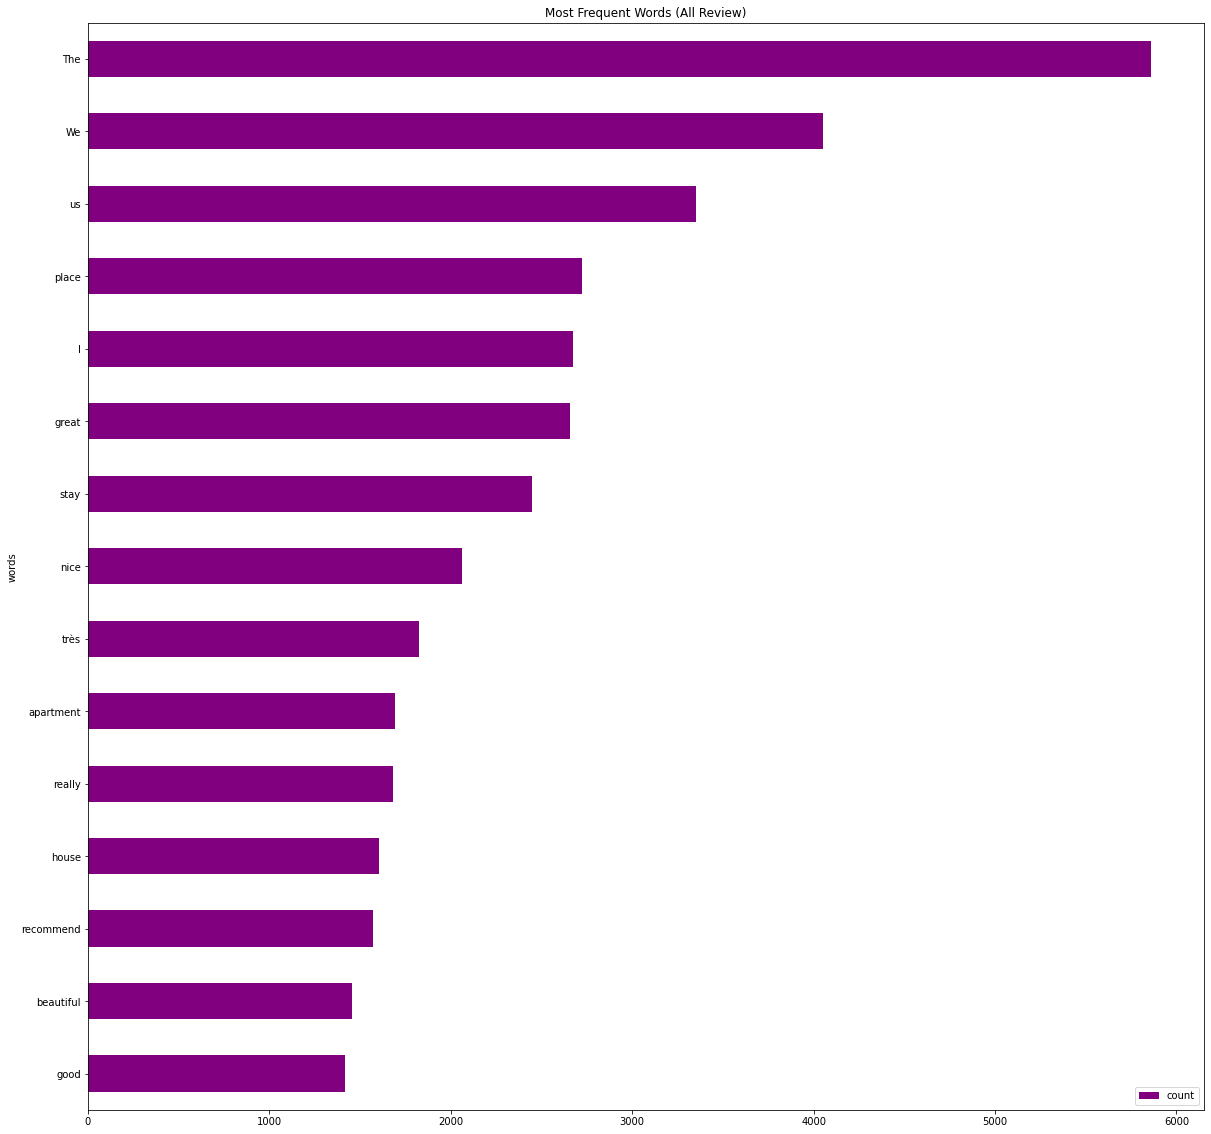

In [13]:
fig, ax = plt.subplots(figsize=(20, 20))

# Plot horizontal bar graph
word_review_count_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words (All Review)")

plt.show()

In [14]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()        

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/katerinatsilingiri/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# since the review comments are in different languages #
# for each review, we try to identify the language and #
# then get the corresponding dictionary.               #

# get the corresponding dictionary for the input language #
# it is needed beacase we are analysing for many languages (6) #
def get_language_likelihood(input_text):
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood

# identify the language #
def get_language(input_text):
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]


In [16]:
reviews_f = [r for r in df['comments'] if pd.notnull(r) and get_language(r) in ['greek', 'english', 'french', 'spanish', 'italian', 'german']]

# calculate the score according to the language #
pscores = [sid.polarity_scores(comment) for comment in reviews_f]

Text(0, 0.5, 'frequency')

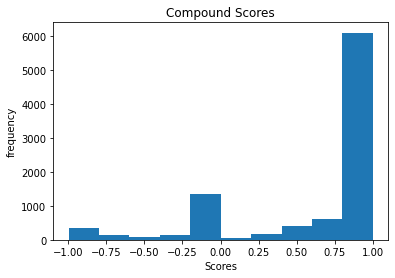

In [17]:
pd.Series([score['compound'] for score in pscores]).plot(kind='hist')

plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

In [18]:
#Create dataframe for sentiment analysis
comments_with_score = pd.DataFrame()
comments_with_score['comment'] = [r for r in reviews_f if get_language(r) in ['greek', 'english', 'french', 'spanish', 'italian', 'german']]
comments_with_score['compound'] = [score['compound'] for score in pscores]
comments_with_score['negativity'] = [score['neg'] for score in pscores]
comments_with_score['neutrality'] = [score['neu'] for score in pscores]
comments_with_score['positivity'] = [score['pos'] for score in pscores]

In [19]:
comments_with_score.query('positivity < negativity')

,comment,compound,negativity,neutrality,positivity
69,Wir hatten eine schöne Zeit in Antonia Apartme...,-0.8439,0.188,0.812,0.000
71,Les moments que nous avons passés avec Antonia...,-0.2732,0.014,0.986,0.000
85,Assurément ma meilleure expérience Airbnb! Man...,-0.5550,0.050,0.950,0.000
111,Sehr empfehlenswert! Antonia und Manolis sind ...,-0.9270,0.120,0.880,0.000
128,Eirini und Vincent waren fabelhafte Gastgeber....,-0.9485,0.114,0.886,0.000
...,...,...,...,...,...
9315,"El apartamento es maravilloso, con vistas incr...",-0.5267,0.141,0.801,0.058
9364,C'est un endroit magnifiquement bien placé en ...,-0.3786,0.036,0.964,0.000
9384,Le coup de coeur de nos vacances ! <br/>Le cad...,-0.5550,0.084,0.916,0.000
9386,Die Lage der Unterkunft ist optimal! Man befin...,-0.7644,0.204,0.732,0.063


In [20]:
comments_with_score.query('positivity > negativity')

,comment,compound,negativity,neutrality,positivity
0,Manolis and his family were wonderful hosta. I...,0.9638,0.000,0.682,0.318
1,Nice apartment. Manolis and his family are lov...,0.9442,0.029,0.812,0.158
2,Antonia was a fantastic host! She will no doub...,0.9808,0.028,0.774,0.198
3,Manolis has an excellent apartment in Amoudara...,0.9985,0.015,0.749,0.237
4,"Everything was wonderful! The weather, beach, ...",0.8955,0.000,0.722,0.278
...,...,...,...,...,...
9402,I highly recommend staying at the Beach Villa....,0.9934,0.000,0.673,0.327
9403,"If I could give six stars, I would. Valia is a...",0.9722,0.000,0.814,0.186
9405,Nice place with lots of sleeping space. Pool w...,0.9749,0.000,0.643,0.357
9406,Valia was excellent before and during our trip...,0.9234,0.029,0.850,0.121


In [21]:
comments_with_score.head()

,comment,compound,negativity,neutrality,positivity
0,Manolis and his family were wonderful hosta. I...,0.9638,0.000,0.682,0.318
1,Nice apartment. Manolis and his family are lov...,0.9442,0.029,0.812,0.158
2,Antonia was a fantastic host! She will no doub...,0.9808,0.028,0.774,0.198
3,Manolis has an excellent apartment in Amoudara...,0.9985,0.015,0.749,0.237
4,"Everything was wonderful! The weather, beach, ...",0.8955,0.000,0.722,0.278


In [22]:
# depending on the value on the 'compound', define if #
# the comment is negative or positive #
def label_comment(row):
    if row['compound'] > 0:
        # positive
        return(1)
    else:
        #negative
        #print("negative review : ", row['comment'])
        return(0)


In [23]:
comments_with_score['class'] = comments_with_score.apply (lambda row : label_comment(row), axis=1)

In [24]:
comments_with_score

,comment,compound,negativity,neutrality,positivity,class
0,Manolis and his family were wonderful hosta. I...,0.9638,0.000,0.682,0.318,1
1,Nice apartment. Manolis and his family are lov...,0.9442,0.029,0.812,0.158,1
2,Antonia was a fantastic host! She will no doub...,0.9808,0.028,0.774,0.198,1
3,Manolis has an excellent apartment in Amoudara...,0.9985,0.015,0.749,0.237,1
4,"Everything was wonderful! The weather, beach, ...",0.8955,0.000,0.722,0.278,1
...,...,...,...,...,...,...
9403,"If I could give six stars, I would. Valia is a...",0.9722,0.000,0.814,0.186,1
9404,The reservation was canceled 183 days before a...,0.0000,0.000,1.000,0.000,0
9405,Nice place with lots of sleeping space. Pool w...,0.9749,0.000,0.643,0.357,1
9406,Valia was excellent before and during our trip...,0.9234,0.029,0.850,0.121,1


# Prepare the data for the classification methods 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

In [26]:
tfidf_vectorizer=TfidfVectorizer(lowercase=True, use_idf=True, max_features = None) 

tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(comments_with_score['comment'])
#print(tfidf_vectorizer_vectors)

In [27]:
X = tfidf_vectorizer_vectors.toarray()
#print(X)

# to make sure that the elements in X are not all 0 
#b=np.sum(X)
#print(b)

Y = comments_with_score['class'][:10000]
#print(Y)

In [28]:
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size = 0.2,  random_state = 0)

In [29]:
#print(X_train)
#b=np.sum(X_train)
#print(b)

In [30]:
enc = preprocessing.LabelEncoder()
y_train_enc = enc.fit_transform(y_train)
y_test_enc = enc.fit_transform(y_test)

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [31]:
lr = LogisticRegression()
lr.fit(X_train, y_train_enc)

LogisticRegression()

In [32]:
y_pred_train = lr.predict(X_train)
y_pred_train = y_pred_train.flatten()
y_pred_test = lr.predict(X_test)

In [33]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
confusion_matrix

array([[ 395,   23],
       [  96, 1368]])

In [34]:
print("Logistic Regression")
print("Accuracy : ", accuracy_score(y_test, y_pred_test))
print("Precision : ", metrics.precision_score(y_test, y_pred_test))

Logistic Regression
Accuracy :  0.936769394261424
Precision :  0.9834651329978433


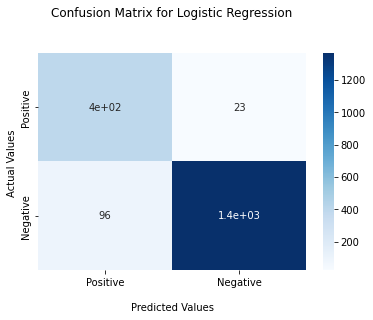

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [36]:
print(classification_report(y_test_enc, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       418
           1       0.98      0.93      0.96      1464

    accuracy                           0.94      1882
   macro avg       0.89      0.94      0.91      1882
weighted avg       0.94      0.94      0.94      1882



## Naive Bayes Classifier

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

gnb = GaussianNB()

In [38]:
gnb.fit(X_train, y_train_enc)

GaussianNB()

In [39]:
y_pred_train = gnb.predict(X_train)

In [40]:
y_pred_test = gnb.predict(X_test)

In [41]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
confusion_matrix

array([[ 334,   84],
       [ 115, 1349]])

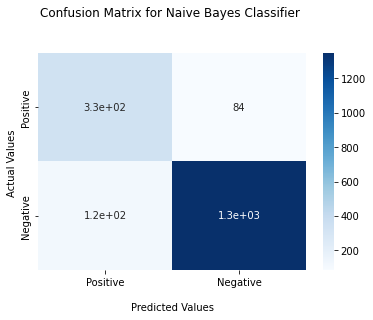

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Naive Bayes Classifier \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [43]:
print("Naive Bayes Classifier")
print("Accuracy : ", accuracy_score(y_test, y_pred_test))
print("Precision : ", metrics.precision_score(y_test, y_pred_test))

Naive Bayes Classifier
Accuracy :  0.8942614240170031
Precision :  0.9413817166782973


In [44]:
print(classification_report(y_test_enc, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       418
           1       0.94      0.92      0.93      1464

    accuracy                           0.89      1882
   macro avg       0.84      0.86      0.85      1882
weighted avg       0.90      0.89      0.90      1882



## Random Forest 

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rf = RandomForestClassifier(n_estimators=50, random_state=2)

rf.fit(X_train, y_train_enc)

RandomForestClassifier(n_estimators=50, random_state=2)

In [47]:
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [48]:
print("Random Forest Classifier")
print("Accuracy : ", accuracy_score(y_test, y_pred_test))

Random Forest Classifier
Accuracy :  0.9282678002125399


In [49]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
confusion_matrix

array([[ 397,   21],
       [ 114, 1350]])

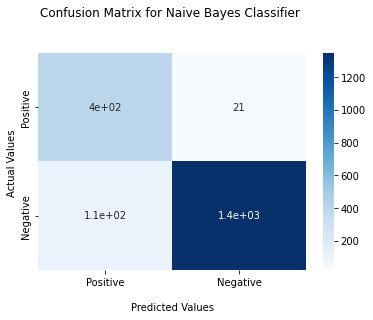

In [50]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Naive Bayes Classifier \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [51]:
print(classification_report(y_test_enc, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.95      0.85       418
           1       0.98      0.92      0.95      1464

    accuracy                           0.93      1882
   macro avg       0.88      0.94      0.90      1882
weighted avg       0.94      0.93      0.93      1882



## AdamBoost

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train_enc)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [35]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[ 392,   26],
       [  52, 1412]])

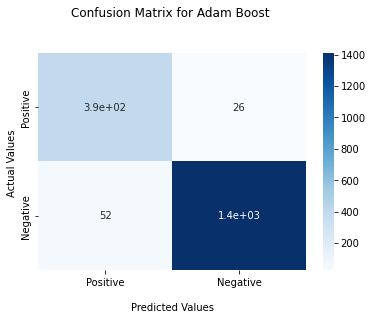

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Adam Boost \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
print("AdamBoost")
print("Accuracy : ", accuracy_score(y_test, y_pred))

AdamBoost
Accuracy :  0.9585547290116897


In [ ]:
print(classification_report(y_test_enc, y_pred))

## SVM Classifier

In [87]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)

In [88]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

In [89]:
svm = SGDClassifier(loss='hinge',max_iter=500)

In [90]:
svm.fit(X_train_transformed, y_train_enc)

SGDClassifier(max_iter=500)

In [91]:
X_test_transformed = scaler.transform(X_test)

In [97]:
y_pred = svm.predict(X_test_transformed)

In [98]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[ 248,  170],
       [  56, 1408]])

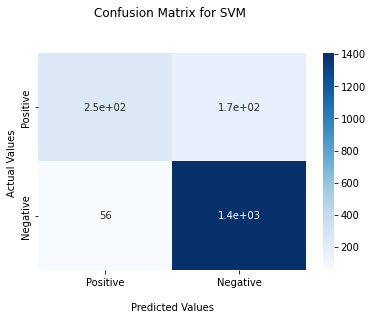

In [99]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for SVM \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [100]:
print("SVM")
print("Accuracy : ", accuracy_score(y_test, y_pred))

SVM
Accuracy :  0.8799149840595112


In [101]:
print(classification_report(y_test_enc, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.59      0.69       418
           1       0.89      0.96      0.93      1464

    accuracy                           0.88      1882
   macro avg       0.85      0.78      0.81      1882
weighted avg       0.88      0.88      0.87      1882



## NN

In [69]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing import sequence

In [74]:
model = Sequential()
model.add(Dense(12, input_dim=26650, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [75]:
X_train.shape

(7526, 26650)

In [76]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [77]:
model.fit(X_train, y_train,
          epochs=150, batch_size = 10)

Epoch 1/150
753/753 [==============================] - 5s 5ms/step - loss: 0.2572 - accuracy: 0.9017
Epoch 2/150
753/753 [==============================] - 3s 4ms/step - loss: 0.1163 - accuracy: 0.9633
Epoch 3/150
753/753 [==============================] - 3s 5ms/step - loss: 0.0454 - accuracy: 0.9902
Epoch 4/150
753/753 [==============================] - 4s 5ms/step - loss: 0.0161 - accuracy: 0.9972
Epoch 5/150
753/753 [==============================] - 4s 5ms/step - loss: 0.0068 - accuracy: 0.9991
Epoch 6/150
753/753 [==============================] - 3s 5ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 7/150
753/753 [==============================] - 4s 5ms/step - loss: 0.0022 - accuracy: 0.9997
Epoch 8/150
753/753 [==============================] - 4s 5ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 9/150
753/753 [==============================] - 4s 5ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 10/150
753/753 [==============================] - 4s 5ms/step - loss: 0.0011 - accura

In [78]:
accuracy = model.evaluate(X, Y)

294/294 [==============================] - 3s 7ms/step - loss: 0.1515 - accuracy: 0.9885
